# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import sys
import os
import logging

import optuna

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_absolute_error, mean_squared_error

from typing import Optional

sys.path.append("../../src")

import embedder
import models
import utils
import train
import dataset

# Data

We should firstly parse the sample basic block data, or load it from pickle if the parsed data have been saved.
The preprocessing steps are based on data analysis done in the data exploration notebook

In [2]:
data_files = os.listdir("../../dataset/bb_data/")

if "energy_dataset.pkl" not in data_files:
    result_files = [f for f in os.listdir("../../../energy_dataset/") if f.endswith("results")] 
    data_df = pd.DataFrame()

    for file in result_files:
        file_df = utils.read_bb_data(f"../../../energy_dataset/{file}/breaker_code.txt", f"../../../energy_dataset/{file}/breaker_final_energy.txt")
        file_df = utils.preprocess_bb_df(file_df)
        data_df = pd.concat([data_df, file_df], ignore_index=True)

    data_df["bb_embeddings"] = data_df.bb.apply(lambda x: embedder.encode(x))
    data_df.to_pickle("../../dataset/bb_data/energy_dataset.pkl")
    
else:
    data_df = pd.read_pickle("../../dataset/bb_data/energy_dataset.pkl")
    if "bb_embeddings" not in data_df.columns:
        data_df["bb_embeddings"] = data_df.bb.apply(lambda x: embedder.encode(x))
        data_df.to_pickle("../../dataset/bb_data/energy_dataset.pkl")

In [3]:
data_df.head(5)

,bb,energy,bb_embeddings
0,[movl $0x0],0.645165,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
1,"[callq, pushq %rbp, mov %rsp %rbp]",2.910575,"[[0.11681142, -0.7584041, 2.0799158, 0.3227231..."
2,"[popq %rbp, retq]",0.997157,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."
3,[movl $0x0],0.664772,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
4,"[cmpl $0x64, jnl 0x2c]",1.400952,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."


# LSTM Model

## Optuna Trials

In [8]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-regression-study-full-dataset"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/lstm-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")

[I 2023-01-19 18:04:03,117] Using an existing study with name 'lstm-regression-study-full-dataset' instead of creating a new one.


Using an existing study with name 'lstm-regression-study-full-dataset' instead of creating a new one.


In [ ]:
def objective(trial):
    
    lstm_layers = trial.suggest_int("lstm_layers", 1, 5)
    hidden_size = trial.suggest_int("hidden_size", 8, 128)
    dense_size = trial.suggest_int("dense_size", 16, 256)
    smaller_dense_size = trial.suggest_int("smaller_dense_size", 8, 64)
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
    dense_dropout = trial.suggest_float("dense_dropout", 0, 0.2)
    lr_decay = trial.suggest_float("lr_decay", 0.05, 0.8)
    lr_decay_step = trial.suggest_int("lr_decay_step", 5, 20)

    batch_size = 2**batch_size_exp

    data_loaders = utils.get_palmtree_data_dict(data_df=data_df, mean=False, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
        smaller_dense_size=smaller_dense_size,
        lstm_dropout=lstm_dropout,
        dense_dropout=dense_dropout,
    )
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
        lr_decay=lr_decay,
        lr_decay_step=lr_decay_step,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]

study.optimize(objective, n_trials=120)

In [10]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_dense_dropout,params_dense_size,params_hidden_size,params_lr,params_lr_decay,params_lr_decay_step,params_lstm_dropout,params_lstm_layers,params_smaller_dense_size,state
18,18,0.413684,2023-01-17 16:32:48.993731,2023-01-17 19:14:57.916231,0 days 02:42:08.922500,3,0.133655,16,85,0.008818,0.414258,13,0.012356,1,15,COMPLETE
26,26,0.422007,2023-01-18 07:18:05.346959,2023-01-18 09:14:53.499311,0 days 01:56:48.152352,3,0.080271,64,116,0.001810,0.231627,11,0.114377,4,29,COMPLETE
21,21,0.422098,2023-01-17 22:05:48.149579,2023-01-18 00:41:47.548583,0 days 02:35:59.399004,3,0.127582,23,92,0.002351,0.354558,11,0.021651,3,14,COMPLETE
33,33,0.422252,2023-01-19 10:24:49.479806,2023-01-19 12:52:25.138441,0 days 02:27:35.658635,3,0.138538,32,113,0.002324,0.289297,10,0.153101,4,19,COMPLETE
24,24,0.422960,2023-01-18 04:21:19.833399,2023-01-18 06:35:07.549895,0 days 02:13:47.716496,3,0.135257,70,118,0.002196,0.313101,11,0.135595,4,28,COMPLETE
22,22,0.423182,2023-01-18 00:41:47.572582,2023-01-18 02:50:54.291350,0 days 02:09:06.718768,3,0.122872,24,98,0.002148,0.439490,11,0.135410,3,15,COMPLETE
23,23,0.423572,2023-01-18 02:50:54.313847,2023-01-18 04:21:19.806388,0 days 01:30:25.492541,3,0.107725,38,98,0.001832,0.496253,5,0.134499,3,14,COMPLETE
30,30,0.428632,2023-01-19 04:59:06.958250,2023-01-19 07:00:27.395082,0 days 02:01:20.436832,3,0.111596,42,105,0.009017,0.210728,7,0.112649,4,31,COMPLETE
31,31,0.428929,2023-01-19 07:00:27.418583,2023-01-19 08:01:42.129806,0 days 01:01:14.711223,3,0.089482,65,117,0.000929,0.087129,8,0.075911,2,38,COMPLETE
19,19,0.434862,2023-01-17 19:14:57.939094,2023-01-17 21:38:34.753829,0 days 02:23:36.814735,3,0.125988,16,61,0.004618,0.458303,11,0.084383,3,15,COMPLETE


In [11]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size_exp': 3, 'dense_dropout': 0.13365451039652823, 'dense_size': 16, 'hidden_size': 85, 'lr': 0.008817673854373346, 'lr_decay': 0.4142584006935689, 'lr_decay_step': 13, 'lstm_dropout': 0.012355725462809754, 'lstm_layers': 1, 'smaller_dense_size': 15}, achieving val RMSE: 0.4136843490934194


## Results

In [4]:
load = False
save = False

batch_size = 2**7

data_loaders = utils.get_palmtree_data_dict(data_df=data_df, mean=False, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = models.LSTM_Regressor(
    embedding_size=embedding_size,
    hidden_size=85,
    num_layers=1,
    dense_size=16,
    smaller_dense_size=15,
    lstm_dropout=0.01,
    dense_dropout=0.13,
)

if load:
    model.load_state_dict(torch.load("../../model_checkpoints/lstm_model"))
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=0.008,
        epochs=200,
        batch_size=2**7,
        verbose=True,
        early_stopping=True,
        lr_decay=0.4,
        lr_decay_step=13,
    )

    if save:
        torch.save(train_results["model"].state_dict(), "../../model_checkpoints/lstm_model")

Epoch: 1/200, RMSE Train Loss: 0.65858, RMSE Val Loss: 0.6374
Epoch: 2/200, RMSE Train Loss: 0.65585, RMSE Val Loss: 0.63982
Epoch: 3/200, RMSE Train Loss: 0.65444, RMSE Val Loss: 0.63643
Epoch: 4/200, RMSE Train Loss: 0.65545, RMSE Val Loss: 0.63408
Epoch: 5/200, RMSE Train Loss: 0.64012, RMSE Val Loss: 0.61035
Epoch: 6/200, RMSE Train Loss: 0.64373, RMSE Val Loss: 0.63685
Epoch: 7/200, RMSE Train Loss: 0.64262, RMSE Val Loss: 0.6296
Epoch: 8/200, RMSE Train Loss: 0.64849, RMSE Val Loss: 0.62931
Epoch: 9/200, RMSE Train Loss: 0.65628, RMSE Val Loss: 0.63792
Epoch: 10/200, RMSE Train Loss: 0.65441, RMSE Val Loss: 0.63796
Epoch: 11/200, RMSE Train Loss: 0.65407, RMSE Val Loss: 0.63786
Epoch: 12/200, RMSE Train Loss: 0.65417, RMSE Val Loss: 0.63831
Epoch: 13/200, RMSE Train Loss: 0.64976, RMSE Val Loss: 0.64107
Epoch: 14/200, RMSE Train Loss: 0.64688, RMSE Val Loss: 0.60624
Epoch: 15/200, RMSE Train Loss: 0.61496, RMSE Val Loss: 0.60067
Epoch: 16/200, RMSE Train Loss: 0.62618, RMSE Val L

KeyboardInterrupt: 

In [13]:
for name, param in model.named_parameters():
    print(name, param.shape)

lstm.weight_ih_l0 torch.Size([340, 128])
lstm.weight_hh_l0 torch.Size([340, 85])
lstm.bias_ih_l0 torch.Size([340])
lstm.bias_hh_l0 torch.Size([340])
dense.weight torch.Size([16, 85])
dense.bias torch.Size([16])
smaller_dense_size.weight torch.Size([15, 16])
smaller_dense_size.bias torch.Size([15])
regressor.weight torch.Size([1, 15])
regressor.bias torch.Size([1])


In [44]:
sizes=[]
for embs, labels in train_loader:
    sizes.append(embs[0].shape[0])

In [7]:
load = False
save = False

batch_size = 2**7

data_loaders = utils.get_palmtree_data_dict(data_df=data_df, mean=False, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = models.LSTM_Regressor(
    embedding_size=embedding_size,
    hidden_size=85,
    num_layers=1,
    dense_size=16,
    smaller_dense_size=15,
    lstm_dropout=0.01,
    dense_dropout=0.13,
)

if load:
    model.load_state_dict(torch.load("../../model_checkpoints/lstm_model"))
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=0.008,
        epochs=200,
        batch_size=2**7,
        verbose=True,
        early_stopping=True,
        lr_decay=0.4,
        lr_decay_step=13,
    )

    if save:
        torch.save(train_results["model"].state_dict(), "../../model_checkpoints/lstm_model")

Epoch: 1/200, RMSE Train Loss: 0.65502, RMSE Val Loss: 0.66288
Epoch: 2/200, RMSE Train Loss: 0.65374, RMSE Val Loss: 0.65478
Epoch: 3/200, RMSE Train Loss: 0.64687, RMSE Val Loss: 0.65799
Epoch: 4/200, RMSE Train Loss: 0.64928, RMSE Val Loss: 0.65778
Epoch: 5/200, RMSE Train Loss: 0.65, RMSE Val Loss: 0.66199
Epoch: 6/200, RMSE Train Loss: 0.64885, RMSE Val Loss: 0.66041
Epoch: 7/200, RMSE Train Loss: 0.65259, RMSE Val Loss: 0.65625
Epoch: 8/200, RMSE Train Loss: 0.64294, RMSE Val Loss: 0.64167
Epoch: 9/200, RMSE Train Loss: 0.6399, RMSE Val Loss: 0.66204
Epoch: 10/200, RMSE Train Loss: 0.64689, RMSE Val Loss: 0.642
Epoch: 11/200, RMSE Train Loss: 0.64772, RMSE Val Loss: 0.65396
Epoch: 12/200, RMSE Train Loss: 0.64916, RMSE Val Loss: 0.65336
Epoch: 13/200, RMSE Train Loss: 0.64642, RMSE Val Loss: 0.65919
Epoch: 14/200, RMSE Train Loss: 0.63755, RMSE Val Loss: 0.64224
Epoch: 15/200, RMSE Train Loss: 0.61845, RMSE Val Loss: 0.6049
Epoch: 16/200, RMSE Train Loss: 0.61272, RMSE Val Loss: 

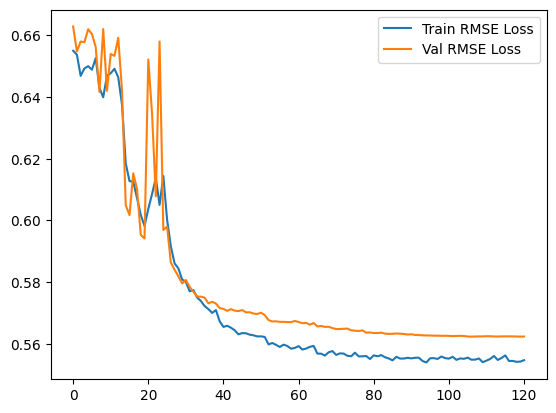

In [8]:
plt.plot(train_results["train_loss"], label="Train RMSE Loss")
plt.plot(train_results["val_loss"], label="Val RMSE Loss")
plt.legend()
plt.show()

In [13]:
pred_dict = train.evaluate(model=model, test_loader=val_loader)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

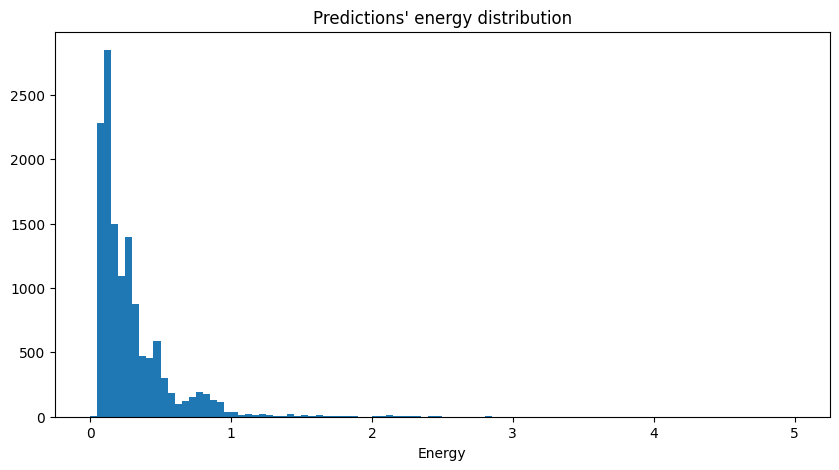

In [14]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

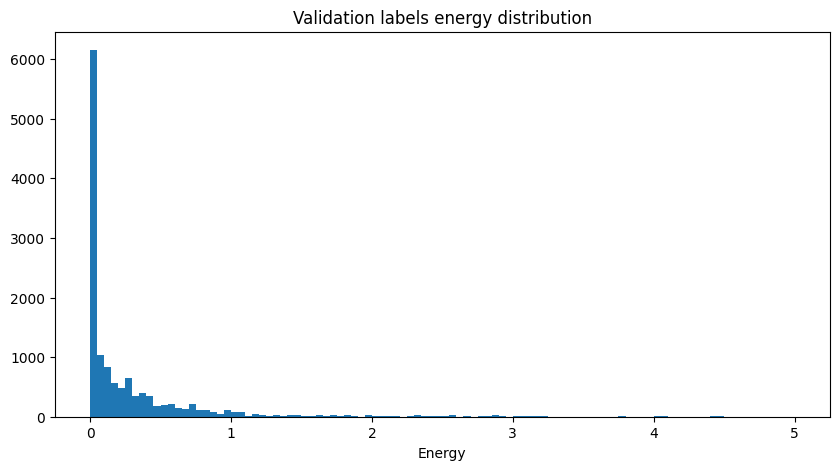

In [15]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [16]:
median = np.median(true_energies)
std = np.std(true_energies)

print(f"Labels' median: {median}, Labels' std: {std}")

Labels' median: 0.07003341420612991, Labels' std: 0.734946507647806


In [17]:
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.35
MAE: 0.283


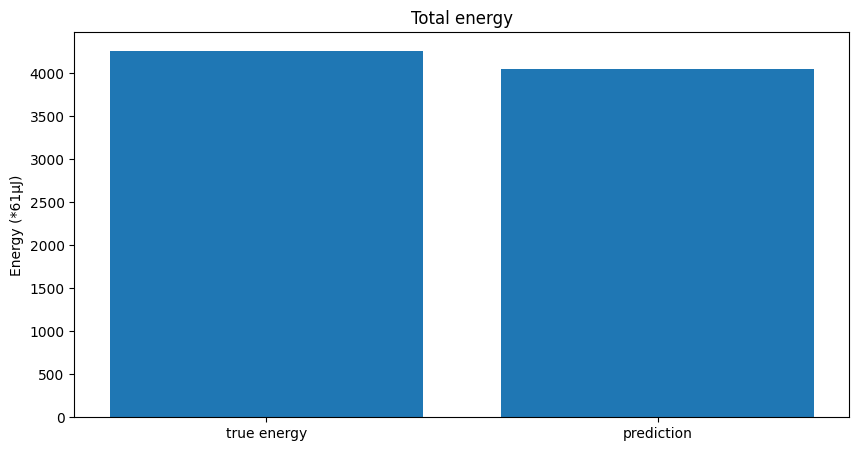

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

# Simple Model

## Optuna Trials

In [28]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "simple_nn-mean_emb-regression-study-good-dataset"
storage_name = f"sqlite:////Users/thodo/Documents/σχολη/diplomatiki/optuna-studies/simple_nn-mean_emb-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RRMSE")

[I 2023-01-11 02:08:48,410] Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.


Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.
Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.
Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.
Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.


In [12]:
def objective(trial):

    num_layers = trial.suggest_int("dense_layers", 1, 6)
    dense_layers = [trial.suggest_int(f"dense_{i}", 8, 256) for i in range(num_layers)]
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    lr_decay = trial.suggest_float("lr_decay", 0.05, 0.8)
    lr_decay_step = trial.suggest_int("lr_decay_step", 5, 20)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    regressor_dropout = trial.suggest_float("regressor_dropout", 0, 0.15)

    batch_size = 2**batch_size_exp

    data_loaders = utils.get_palmtree_data_dict(data_df=data_df, mean=True, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.Simple_Regressor(
        embedding_size=embedding_size,
        layers=dense_layers,
        dropout=dropout,
        regressor_dropout=regressor_dropout,
    )

    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
        lr_decay=lr_decay,
        lr_decay_step=lr_decay_step,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=120)

[I 2023-01-09 14:08:28,492] Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.


Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.
Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.


In [29]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_dense_0,params_dense_1,params_dense_2,params_dense_3,params_dense_4,params_dense_5,params_dense_layers,params_dropout,params_learning_rate_exp,params_regressor_dropout,state
55,55,0.439975,2023-01-09 06:17:46.434492,2023-01-09 06:30:07.847971,0 days 00:12:21.413479,3,162,NaN,NaN,NaN,NaN,NaN,1,0.184660,-3,0.000839,COMPLETE
77,77,0.481107,2023-01-09 09:51:28.306257,2023-01-09 09:57:56.392646,0 days 00:06:28.086389,4,203,NaN,NaN,NaN,NaN,NaN,1,0.153568,-3,0.017584,COMPLETE
60,60,0.483190,2023-01-09 07:21:23.597985,2023-01-09 07:27:57.998985,0 days 00:06:34.401000,4,176,NaN,NaN,NaN,NaN,NaN,1,0.172506,-3,0.006142,COMPLETE
63,63,0.493283,2023-01-09 07:48:39.618658,2023-01-09 08:01:33.299750,0 days 00:12:53.681092,3,137,NaN,NaN,NaN,NaN,NaN,1,0.058225,-3,0.003660,COMPLETE
37,37,0.511997,2023-01-09 04:05:56.400867,2023-01-09 04:09:12.563638,0 days 00:03:16.162771,5,235,NaN,NaN,NaN,NaN,NaN,1,0.167221,-3,0.140379,COMPLETE
48,48,0.532418,2023-01-09 04:48:09.741557,2023-01-09 05:00:30.477013,0 days 00:12:20.735456,3,158,NaN,NaN,NaN,NaN,NaN,1,0.189842,-3,0.019822,COMPLETE
22,22,0.532783,2023-01-09 03:07:39.123335,2023-01-09 03:10:55.686098,0 days 00:03:16.562763,5,221,NaN,NaN,NaN,NaN,NaN,1,0.173118,-3,0.121949,COMPLETE
47,47,0.540323,2023-01-09 04:41:54.784896,2023-01-09 04:48:09.722564,0 days 00:06:14.937668,4,160,NaN,NaN,NaN,NaN,NaN,1,0.153256,-3,0.134953,COMPLETE
92,92,0.541284,2023-01-09 11:48:51.572990,2023-01-09 12:02:42.010988,0 days 00:13:50.437998,3,60,NaN,NaN,NaN,NaN,NaN,1,0.151706,-3,0.132688,COMPLETE
64,64,0.541902,2023-01-09 08:01:33.318743,2023-01-09 08:07:45.494753,0 days 00:06:12.176010,4,112,NaN,NaN,NaN,NaN,NaN,1,0.044553,-3,0.000672,COMPLETE


In [30]:
print(f"Best simple-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best simple-regressor-model params: {'batch_size_exp': 3, 'dense_0': 162, 'dense_layers': 1, 'dropout': 0.18466029305173945, 'learning_rate_exp': -3, 'regressor_dropout': 0.0008387692491181251}, achieving val MSE: 0.43997468536312434


## Results

In [2]:
load = False
save = False

data_loaders = utils.get_palmtree_data_dict(data_df=data_df, mean=True, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = models.Simple_Regressor(
    embedding_size=embedding_size, layers=[162], regressor_dropout=8e-4
)

if load:
    model.load_state_dict(torch.load("../../model_checkpoints/simple_model"))
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=10e-3,
        epochs=200,
        batch_size=2**3,
        verbose=True,
        early_stopping=True,
        lr_decay=0.1,
        lr_decay_step=10,
    )
    if save:
        torch.save(model.state_dict(), "../../model_checkpoints/simple_model")

NameError: name 'get_data_dict' is not defined

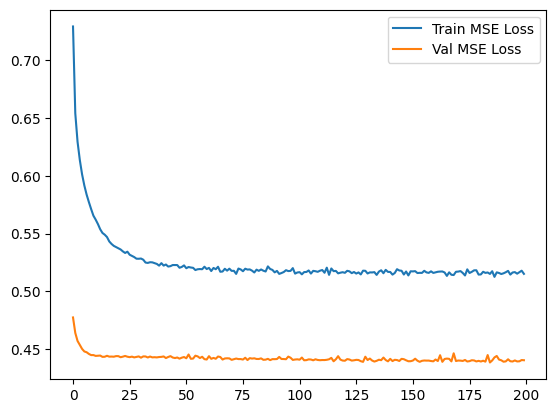

In [ ]:
plt.plot(train_results["train_loss"], label="Train RMSE Loss")
plt.plot(train_results["val_loss"], label="Val RMSE Loss")
plt.legend()
plt.show()

In [ ]:
pred_dict = train.evaluate(model=model, test_loader=val_loader)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

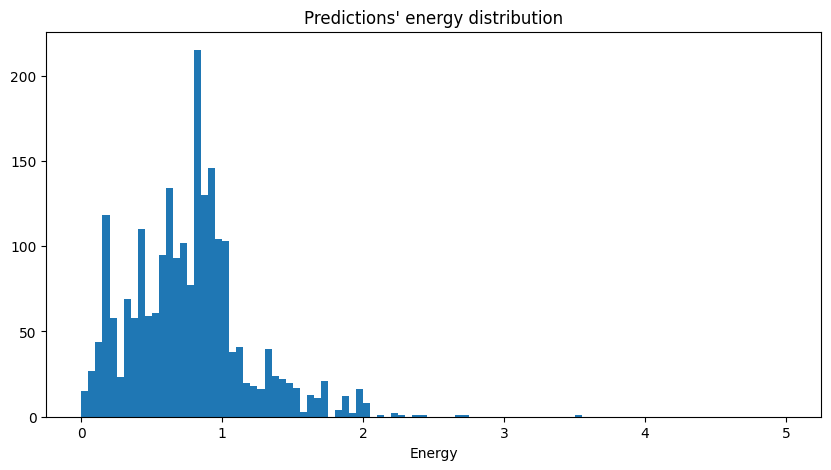

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

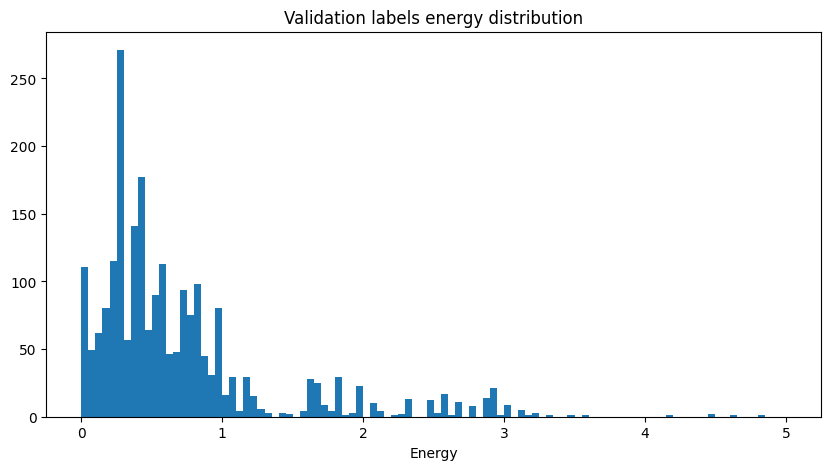

In [ ]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [ ]:
median = np.median(true_energies)
std = np.std(true_energies)

print(f"Labels' median: {median}, Labels' std: {std}")

In [ ]:
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()